In [20]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import zscore
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn import metrics

from sklearn.model_selection import GridSearchCV, KFold
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler, MinMaxScaler, RobustScaler

%matplotlib inline

import lightgbm as lgb
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
import warnings
warnings.filterwarnings("ignore")

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/tabular-playground-series-feb-2021/sample_submission.csv
/kaggle/input/tabular-playground-series-feb-2021/train.csv
/kaggle/input/tabular-playground-series-feb-2021/test.csv


In [7]:
train_df = pd.read_csv('../input/tabular-playground-series-feb-2021/train.csv')
#print('Train data dimension: ', train_df.shape)

test_df = pd.read_csv('../input/tabular-playground-series-feb-2021/test.csv')
#print('Test data dimension: ', test_df.shape)

sample_submission = pd.read_csv('../input/tabular-playground-series-feb-2021/sample_submission.csv')

In [17]:
test_df.head(5)

,id,cat0,cat1,cat2,cat3,cat4,cat5,cat6,cat7,cat8,...,cont4,cont5,cont6,cont7,cont8,cont9,cont10,cont11,cont12,cont13
0,0,A,B,A,C,B,D,A,E,E,...,0.701679,0.595507,0.286912,0.279884,0.202234,0.242654,0.285147,0.264308,0.653654,0.302448
1,5,A,B,A,C,B,D,A,E,C,...,0.277480,0.479552,0.397436,0.476742,0.857073,0.516393,0.562065,0.730542,0.318492,0.736251
2,15,A,B,A,C,B,D,A,E,C,...,0.279508,0.676395,0.695284,0.253316,0.586934,0.548555,0.836193,0.759788,0.333572,0.273905
3,16,A,A,B,A,B,D,A,E,E,...,0.479503,0.759875,0.240049,0.298074,0.442475,0.596746,0.414131,0.255382,0.589080,0.311625
4,17,A,B,A,A,B,B,A,E,E,...,0.757845,0.210232,0.329851,0.616663,0.170475,0.263235,0.710961,0.224045,0.285860,0.794931


In [18]:
train_df.describe().T

,count,mean,std,min,25%,50%,75%,max
id,300000.0,250018.576947,144450.150010,1.000000,124772.500000,250002.500000,375226.500000,499999.000000
cont0,300000.0,0.524634,0.204875,-0.093505,0.370451,0.492208,0.654793,1.052666
cont1,300000.0,0.506649,0.235269,-0.055105,0.352307,0.615156,0.688150,0.851746
cont2,300000.0,0.444115,0.200089,-0.060274,0.314121,0.457271,0.554835,1.017689
cont3,300000.0,0.446214,0.238669,0.134760,0.214572,0.377823,0.719758,1.006469
cont4,300000.0,0.455471,0.200695,0.189216,0.279853,0.411351,0.621808,0.994050
cont5,300000.0,0.508337,0.231612,-0.087247,0.338747,0.441384,0.709515,1.044433
cont6,300000.0,0.478345,0.192432,0.043953,0.339896,0.410090,0.604246,1.093312
cont7,300000.0,0.455904,0.204493,0.208703,0.278041,0.360736,0.639388,1.036541
cont8,300000.0,0.459321,0.220642,0.004041,0.308655,0.425801,0.541525,1.014156


In [19]:
print(f"Missing data in the train data: {train_df.isna().sum(axis=0).any()}")
print(f"Missing data in the test data: {test_df.isna().sum(axis=0).any()}")

Missing data in the train data: False
Missing data in the test data: False


### Numerical Features

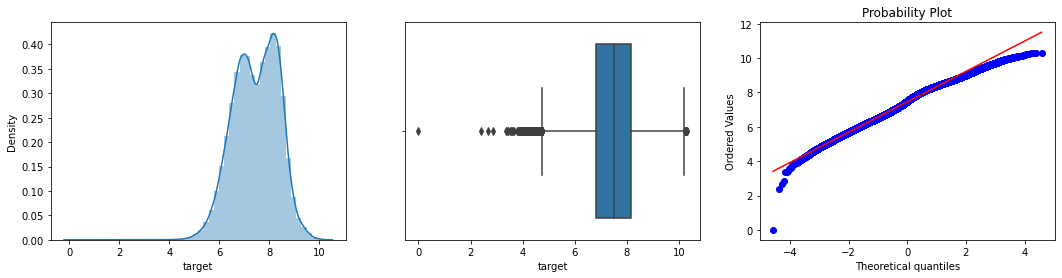

In [20]:
f, ax = plt.subplots(nrows=1, ncols=3, figsize=(18, 4))
sns.distplot(train_df.target, ax=ax[0])
sns.boxplot(train_df.target, ax=ax[1])
stats.probplot(train_df['target'], plot=ax[2])
plt.show()

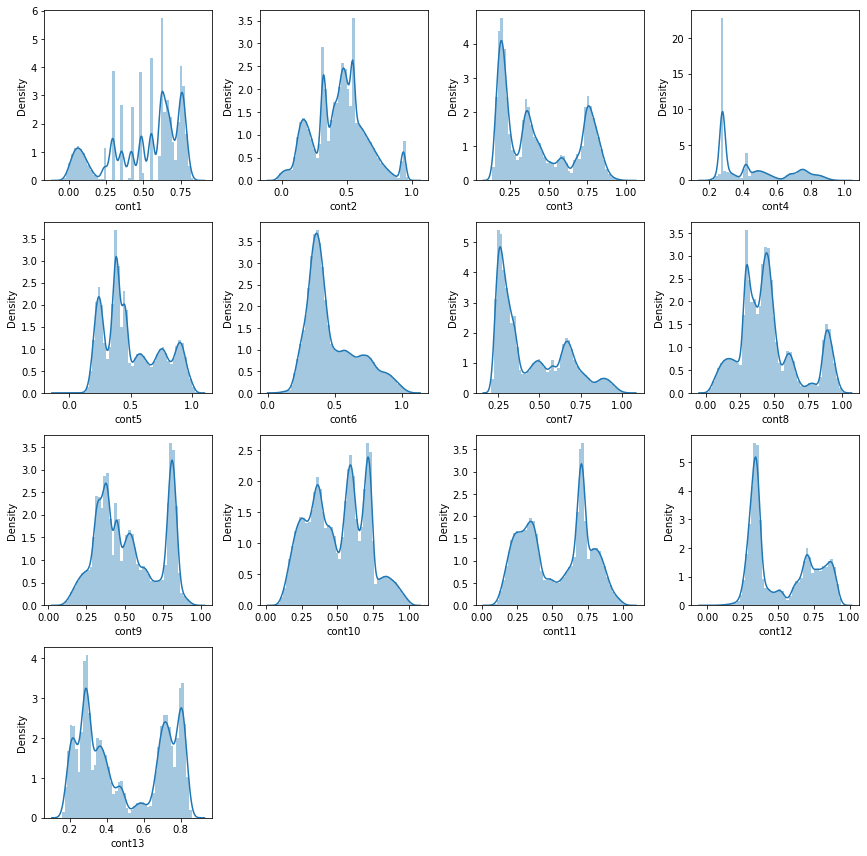

In [21]:
f, ax = plt.subplots(nrows=4, ncols=4, figsize=(12, 12))
#f.suptitle('Distribution of Features', fontsize=16)
sns.distplot(train_df['cont1'], ax=ax[0, 0])
sns.distplot(train_df['cont2'], ax=ax[0, 1])
sns.distplot(train_df['cont3'], ax=ax[0, 2])
sns.distplot(train_df['cont4'], ax=ax[0, 3])

sns.distplot(train_df['cont5'], ax=ax[1, 0])
sns.distplot(train_df['cont6'], ax=ax[1, 1])
sns.distplot(train_df['cont7'], ax=ax[1, 2])
sns.distplot(train_df['cont8'], ax=ax[1, 3])

sns.distplot(train_df['cont9'], ax=ax[2, 0])
sns.distplot(train_df['cont10'], ax=ax[2, 1])
sns.distplot(train_df['cont11'], ax=ax[2, 2])
sns.distplot(train_df['cont12'], ax=ax[2, 3])

sns.distplot(train_df['cont13'], ax=ax[3, 0])

f.delaxes(ax[3, 1])
f.delaxes(ax[3, 2])
f.delaxes(ax[3, 3])

plt.tight_layout()
plt.show()

<AxesSubplot:>

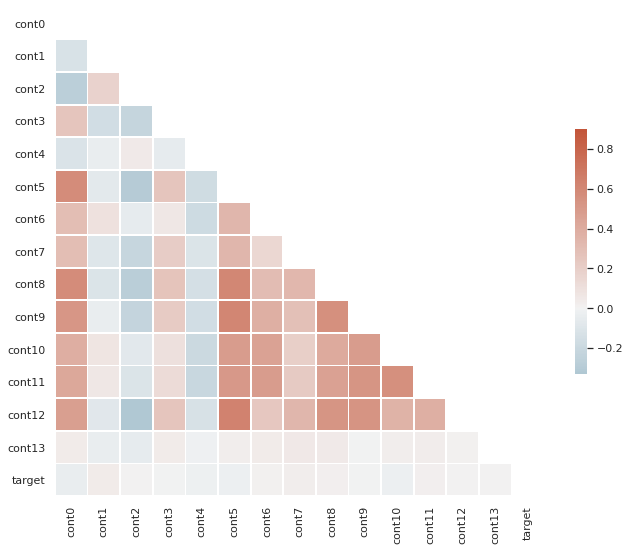

In [22]:
train_df_corr = train_df.drop(['id'], axis = 1)

sns.set_theme(style="white")

# Generate a large random dataset
#rs = np.random.RandomState(33)
#d = pd.DataFrame(data=rs.normal(size=(100, 26)), columns=list(ascii_letters[26:]))

# Compute the correlation matrix
corr = train_df_corr.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=0.9, center=0,
            square=True, linewidths=.8, cbar_kws={"shrink": .5})

### Categorical Features

In [2]:
features_cat = ['cat0', 'cat1', 'cat2', 'cat3', 'cat4', 'cat5', 'cat6', 'cat7', 'cat8', 'cat9']

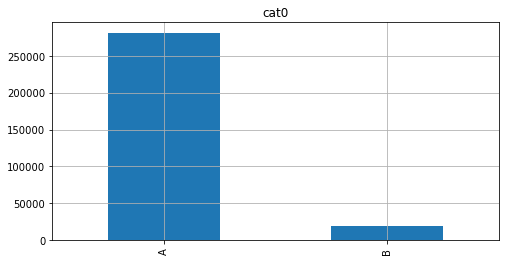

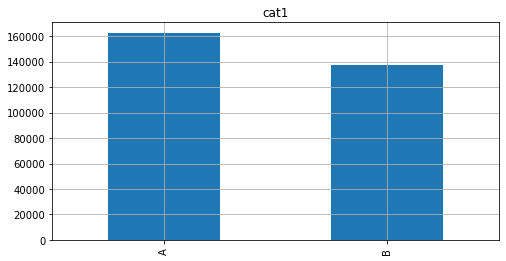

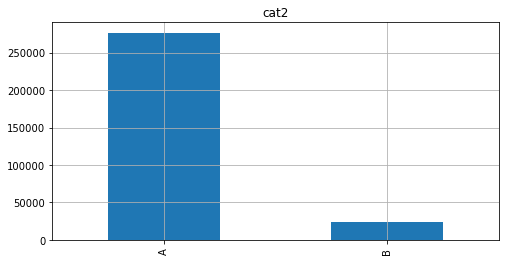

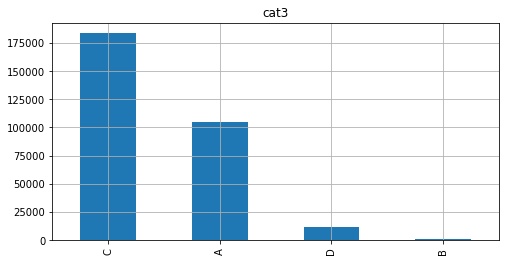

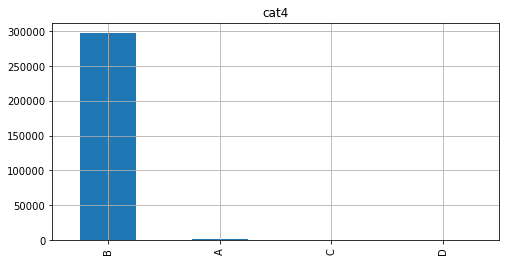

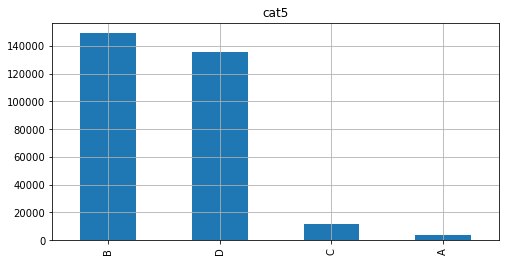

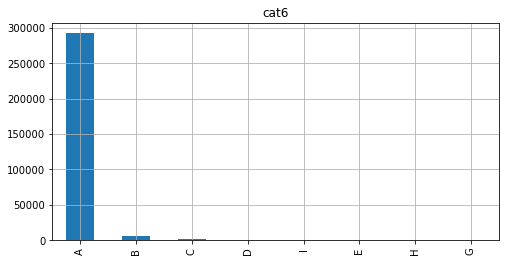

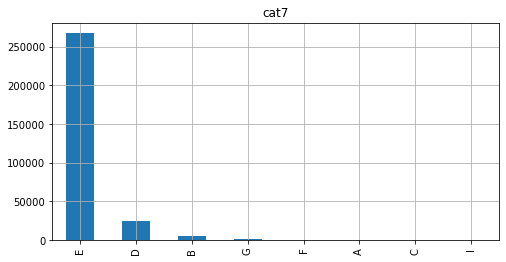

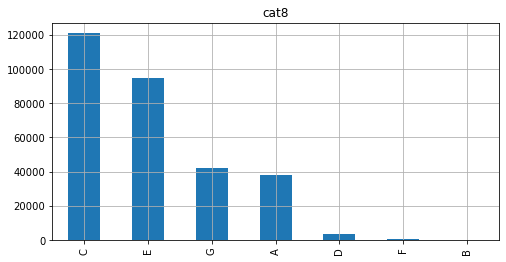

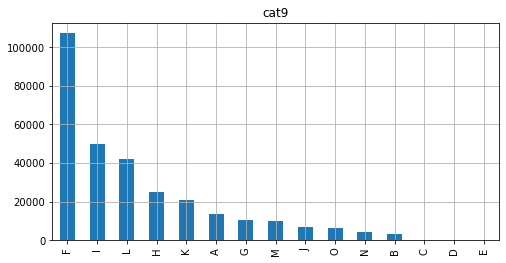

In [8]:
for f in features_cat:
    plt.figure(figsize=(8,4))
    train_df[f].value_counts().plot(kind='bar')
    plt.title(f)
    plt.grid()
    plt.show()

In [ ]:
# Categorical Features vs Target

for f in features_cat:
    plt.figure(figsize=(10,5))
    sns.boxplot(data=train_df, x=f, y='target')
    plt.xticks(rotation=90)
    plt.grid()
    plt.show()

### Data Cleaning

In [ ]:
# Drop one outlier
train_df = train_df[train_df.target != 0].reset_index(drop=True)

## Model Build

In [11]:
# Base model with target average as prediction

target_mean = np.mean(train_df['target'])
target_mean

7.456260484377302

In [ ]:
baseline_pred = train_df.target - target_mean # difference target vs. trivial mean prediction
baseline_pred = (baseline_pred*baseline_pred).mean() # mean squared error
print('RMSE(train) - Trivial Benchmark: ', np.round(np.sqrt(baseline_pred),6))

#### Train Test Split

In [24]:
X = train_df.drop(['id','target'], axis = 1)
y = train_df[["target"]]
test_size = 0.30
seed = 7
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=seed)

### Random Forest

#### Category Encoding

In [21]:
# Label Encoding

for c in features_cat:
    le = LabelEncoder()
    le.fit(list(train_df[c].astype(str)) + list(test_df[c].astype(str)))
    train_df[c] = le.transform(train_df[c].astype(str))
    test_df[c] = le.transform(test_df[c].astype(str))
    le_name_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
    print('target mapping :  ',c ,  le_name_mapping)

target mapping :   cat0 {'A': 0, 'B': 1}
target mapping :   cat1 {'A': 0, 'B': 1}
target mapping :   cat2 {'A': 0, 'B': 1}
target mapping :   cat3 {'A': 0, 'B': 1, 'C': 2, 'D': 3}
target mapping :   cat4 {'A': 0, 'B': 1, 'C': 2, 'D': 3}
target mapping :   cat5 {'A': 0, 'B': 1, 'C': 2, 'D': 3}
target mapping :   cat6 {'A': 0, 'B': 1, 'C': 2, 'D': 3, 'E': 4, 'G': 5, 'H': 6, 'I': 7}
target mapping :   cat7 {'A': 0, 'B': 1, 'C': 2, 'D': 3, 'E': 4, 'F': 5, 'G': 6, 'I': 7}
target mapping :   cat8 {'A': 0, 'B': 1, 'C': 2, 'D': 3, 'E': 4, 'F': 5, 'G': 6}
target mapping :   cat9 {'A': 0, 'B': 1, 'C': 2, 'D': 3, 'E': 4, 'F': 5, 'G': 6, 'H': 7, 'I': 8, 'J': 9, 'K': 10, 'L': 11, 'M': 12, 'N': 13, 'O': 14}


In [22]:
from sklearn.ensemble import RandomForestRegressor

In [25]:
%%time

forestReg = RandomForestRegressor(n_estimators=100, random_state=2, max_depth = 6)
forestReg.fit(X_train, y_train)

CPU times: user 2min 37s, sys: 72.4 ms, total: 2min 37s
Wall time: 2min 38s


RandomForestRegressor(max_depth=6, random_state=2)

In [26]:
predicted_labels = forestReg.predict(X_test)
forestReg.score(X_test, y_test)
score = np.sqrt(mean_squared_error(y_test, predicted_labels))
score

0.8658272684534501

In [27]:
test_df2 = test_df.drop(['id'], axis = 1)

#Predict test data 
pred_test = forestReg.predict(test_df2)

In [28]:
submission = test_df[['id']].copy()
submission['target'] = pred_test

submission.to_csv("submission.csv", index=False)

In [29]:
### LightGBM

### LightGBM